# IMDB with pytorch but using keras data

I just realized that I was using a mere 2000 records and the keras book and examples were using a much larger 25000 (train and also test) data set. So I'm going to use keras to pull that data and but process it using PyTorch.

In [1]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def train_test_split(X, y, test_size:float):
    n = len(X)
    shuffle_idx = np.random.permutation(range(n))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    n_valid = int(n*test_size)
    n_train = n - n_valid
    X_train, X_valid = X[0:n_train].to(device), X[n_train:].to(device)
    y_train, y_valid = y[0:n_train].to(device), y[n_train:].to(device)
    return X_train, X_valid, y_train, y_valid

In [3]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

## Load IMDb from keras

In [4]:
import numpy as np
import tensorflow as tf
from keras.datasets import imdb
from keras import preprocessing

Using TensorFlow backend.


In [5]:
max_features = vocab_size = 10_000
maxlen = ndocprefix = 20
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

In [6]:
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [7]:
X_train = torch.tensor(X_train).long().to(device)
X_test = torch.tensor(X_test).long().to(device)
y_train = torch.tensor(y_train).float().reshape(-1,1).to(device)
y_test = torch.tensor(y_test).float().reshape(-1,1).to(device)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 0.20)

## Train

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [10]:
class IMBD(TensorDataset):
    def __init__(self, X, y):
        super().__init__(X, y)
        self.X = X # track with easy to use fields
        self.y = y

In [11]:
from sklearn.metrics import accuracy_score
def train(model, train_data, valid_data,
          epochs=350,
          test_size=0.20,
          learning_rate = 0.002,
          batch_size=32,
          weight_decay=1.e-4,
          loss_fn=nn.BCELoss(),
          print_every=30):
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
            loss = loss_fn(y_prob, batch_y) 

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()
        
        with torch.no_grad():
            loss        = loss_fn(model(train_data.X), train_data.y)
            loss_valid  = loss_fn(model(valid_data.X), valid_data.y)
            accur_train = accuracy_score(torch.round(model(train_data.X).cpu()), train_data.y.cpu())
            accur_valid = accuracy_score(torch.round(model(valid_data.X).cpu()), valid_data.y.cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} log loss {loss:7.3f}, {loss_valid:7.3f}   accuracy {accur_train:4.3f}, {accur_valid:4.3f}")        

    history = torch.tensor(history)
    return model, history

In [12]:
class Sentiment(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(Sentiment, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.final = nn.Linear(ndocprefix*nfactors,1)
        
    def forward(self, x):
#         print(x.device)       # cuda:0 or cpu
#         print(x.shape)      # [1600, 20]
        output = self.embedding(x)
#         print(output.shape) # [1600, 20, 8] = (samples, num word features, embedding dim)
        # must cat the 20 64-vectors together
        output = output.view((x.shape[0], -1))
#         print(output.shape) # [1600, 160]
        output = self.final(output)
#         print(output.shape) # [1600, 1]
        return torch.sigmoid(output)

20000 training and 5000 test records
Epoch   0 log loss   0.466,   0.535   accuracy 0.777, 0.728
Epoch   1 log loss   0.435,   0.531   accuracy 0.796, 0.732
Epoch   2 log loss   0.427,   0.528   accuracy 0.804, 0.742
Epoch   3 log loss   0.426,   0.528   accuracy 0.804, 0.742
Epoch   4 log loss   0.421,   0.527   accuracy 0.807, 0.740
Epoch   5 log loss   0.415,   0.524   accuracy 0.811, 0.741
Epoch   6 log loss   0.416,   0.525   accuracy 0.812, 0.743
Epoch   7 log loss   0.416,   0.527   accuracy 0.811, 0.745
Epoch   8 log loss   0.416,   0.528   accuracy 0.812, 0.746
Epoch   9 log loss   0.416,   0.527   accuracy 0.810, 0.744


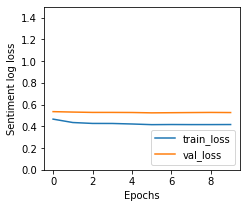

In [13]:
nfactors = 6
model = Sentiment(vocab_size, nfactors).to(device)

print(f"{len(X_train)} training and {len(X_valid)} test records")
model, history = train(model, IMBD(X_train, y_train), IMBD(X_valid, y_valid),
                       epochs=10,
                       learning_rate=.03,
                       weight_decay=0.0001,
                       batch_size=32,
                       print_every=1)

plot_history(history, yrange=(0,1.5))

Whew! Ok,Getting the same rough accuracy that those guys do from the book. They said about 76% accurate.

## Add more layers and dropout

In [14]:
import torch
import torch.nn as nn

layer1 = 64
layer2 = 32
class SentimentRegularized(nn.Module):
    def __init__(self, vocab_size, nfactors):
        super(SentimentRegularized, self).__init__()
        self.embedding = nn.Embedding(vocab_size, nfactors)
        self.layers = nn.Sequential(
            nn.Linear(ndocprefix*nfactors,layer1), # 300 neurons
#            nn.BatchNorm1d(layer1),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=layer1, out_features=layer2),
#            nn.BatchNorm1d(layer2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(layer2,1)
        )
        
    def forward(self, x):
        output = self.embedding(x)
        output = output.view((x.shape[0], -1))
        output = self.layers(output)
        return torch.sigmoid(output)

In [15]:
nfactors = 8
model = SentimentRegularized(vocab_size, nfactors).to(device)

print(f"{len(X_train)} training and {len(X_valid)} test records")
model, history = train(model, IMBD(X_train, y_train), IMBD(X_valid, y_valid),
                       epochs=15,
                       learning_rate=.01,
                       weight_decay=0.0,#0001,
                       batch_size=16,
                       print_every=1)

plot_history(history, yrange=(0,1.0))

20000 training and 5000 test records


KeyboardInterrupt: 